In [42]:
import sys
sys.path.append('/Users/laurenthericourt/projets/trading/trading')
import warnings
warnings.filterwarnings('ignore')
import random

import pandas as pd
pd.set_option('display.max_rows', 500)
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from config.load import load_conf
from db.utils import get_uri_db
from utils.utils import get_candles
from indicator.trend import ExponentialMovingAverage
from notebooks.compute_indicators import moyenne_mobile_features
from utils.utils import compute_sign_changement
from notebooks.display_indicators import show_candle, add_indicator
from strategy.examples.sma5_sma10_sma200 import Sma5Sma10Sma200
from strategy.examples.macd_strat import MacdStrat

# Get data

In [43]:
load_conf('../config/configuration.yaml')
dsn = get_uri_db()
schema = 'trading'

In [ ]:
start_date = '2019-01-01'
end_date = '2021-01-01'

candles = get_candles(dsn, schema, start_date, end_date)

In [ ]:
candles.head()

# Compute indicator

In [16]:
table = 'candle15m'
symbol = 'EUR/USD'

candles_to_show = candles[(candles['table'] == table) & (candles['symbol'] == symbol)]

# Show data
## Full graph

In [7]:
candles_to_show.head()

table                date   symbol     open    close      low  \
1910806  candle4h 2019-01-02 04:00:00  EUR/USD  1.14459  1.14775  1.14459   
1910807  candle4h 2019-01-02 08:00:00  EUR/USD  1.14775  1.14345  1.14228   
1910808  candle4h 2019-01-02 12:00:00  EUR/USD  1.14345  1.13546  1.13426   
1910809  candle4h 2019-01-02 16:00:00  EUR/USD  1.13546  1.13444  1.13258   
1910810  candle4h 2019-01-02 20:00:00  EUR/USD  1.13444  1.13134  1.13103   

            high  tickqty  ema8      ema5  ema5_minus_ema8  \
1910806  1.14975    33013   NaN       NaN              NaN   
1910807  1.14788    94684   NaN       NaN              NaN   
1910808  1.14348   123076   NaN       NaN              NaN   
1910809  1.13629    72031   NaN       NaN              NaN   
1910810  1.13648    49071   NaN  1.135458              NaN   

         ema5_minus_ema8_pos  ema5_minus_ema8_neg  
1910806                    0                    0  
1910807                    0                    0  
1910808                    0                    0  
1910809                    0                    0  
1910810                    0                    0

In [18]:
strat = MacdStrat(candles_to_show, 1)
strat.apply_strategy(1e-5)

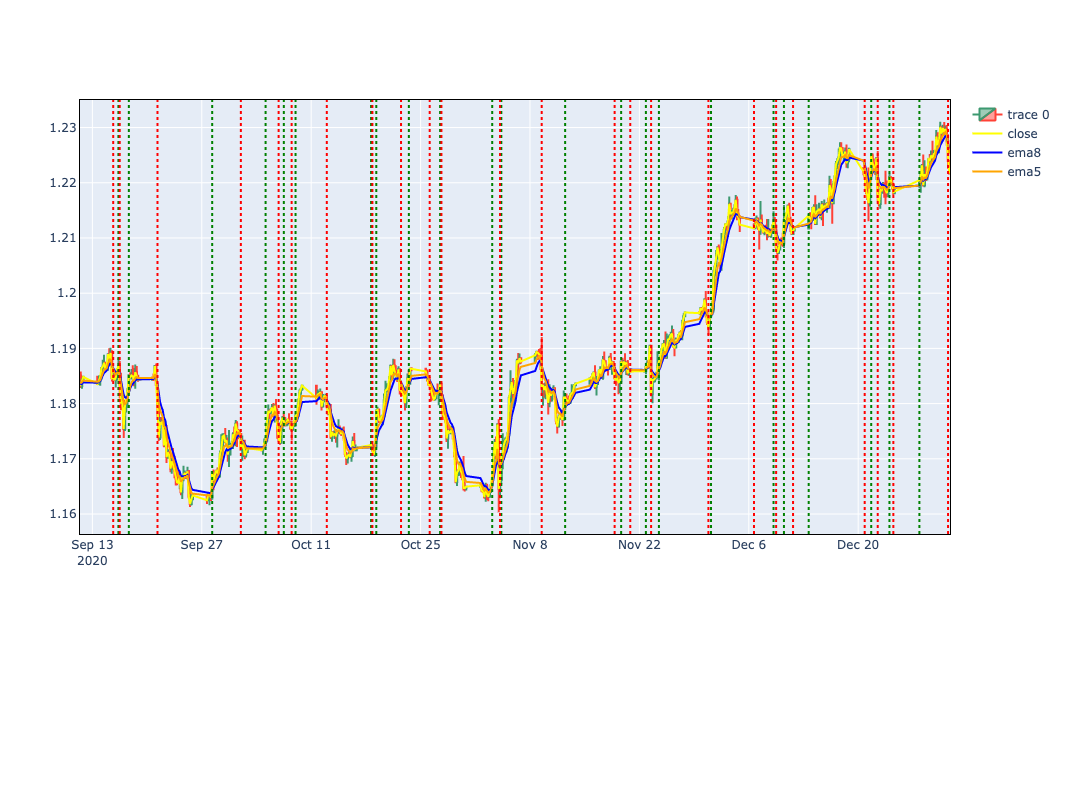

In [27]:
data = cMacdStratdles_to_show.tail(500)
fig = show_candle(data, size=(1000, 800))

fig = add_indicator(data[['date', 'close']], fig, 'close', color='yellow')

for indicator_name, color in  [('ema8', 'blue'), ('ema5', 'orange')]:
    fig = add_indicator(data[['date', indicator_name]], fig, indicator_name, color=color)

for indicator_name, color in [('ema5_minus_ema8_pos', 'green'), ('ema5_minus_ema8_neg', 'red')]:
    data_tmp = data[data[indicator_name] == 1]
    for row in data_tmp.itertuples():
        fig.add_vline(x=row.date, line_dash='dot', line_color=color)

fig.show()

## Exemples

In [26]:
indicator_name = 'action'
nb_examples_to_show = 30
nb_candles_to_show = 100
candles_to_show = strat.data
possible_idx = candles_to_show[candles_to_show[indicator_name].isin([-1, 1])].index.tolist()
random.shuffle(possible_idx)
idx_to_show = possible_idx[:nb_examples_to_show]

In [27]:
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import numpy as np

span = 5
slopes = list()

def compute_slope(candles, idx, span=5, before=True):
    if before:
        y = candles.loc[idx - span + 1:idx, ['close']]
    else:
        y = candles.loc[idx: idx + span - 1, ['close']]
    x = np.arange(span).reshape((span, 1))
    y_scaled = (y - y.min()) / (y.max() - y.min())
    if len(y_scaled[y_scaled.isnull().any(axis=1)]):
        return 0
    x_scaled = (x - x.min()) / (x.max() - x.min())
    lr = LinearRegression()
    try:
        lr.fit(x_scaled, y_scaled)
    except:
        return 0
    return np.rad2deg(np.arctan(lr.coef_[0]))[0]

slopes_after = [compute_slope(candles_to_show, i, before=False) for i in tqdm(possible_idx)]
slopes_before = [compute_slope(candles_to_show, i) for i in tqdm(possible_idx)]


100%|██████████| 7280/7280 [00:31<00:00, 233.74it/s]


In [28]:
candles_to_show['slope_before'] = 0
candles_to_show['slope_after'] = 0
candles_to_show.loc[possible_idx, 'slope_before'] = slopes_before
candles_to_show.loc[possible_idx, 'slope_after'] = slopes_after

In [29]:
candles_to_show[(candles_to_show[indicator_name] == -1)].shape

(3640, 19)

In [41]:
mask = (candles_to_show[indicator_name] == 1) & (candles_to_show['slope_before'] > 30)
candles_to_show.loc[mask, ['slope_after']].shape

(1482, 1)

In [38]:
def show_random_cases(candles, indicator_name, nb_examples_to_show=30, nb_candles_to_show=50):
    possible_idx = candles[(candles[indicator_name] == 1) & (candles_to_show['slope_before'] > 30) & (candles['ret'] == 0)].index.tolist()
    random.shuffle(possible_idx)
    idx_to_show = possible_idx[:nb_examples_to_show]

    range_of_idx_to_show = [(x - nb_candles_to_show // 2, x + nb_candles_to_show // 2) for x in idx_to_show]
    
    for i, (idx_start, idx_end) in enumerate(range_of_idx_to_show):
        data = candles.loc[idx_start: idx_end, :]
        idx = nb_candles_to_show // 2 + idx_start
        data_tmp = data.loc[idx, :]
    
        if i % 2 == 0:
            fig = make_subplots(rows=1, cols=2)
        fig.update_layout(xaxis1_rangeslider_visible=False, xaxis2_rangeslider_visible=False)
        fig.update_yaxes(fixedrange=False)

        fig.add_trace(go.Candlestick(x=data['date'],
                                     open=data['open'],
                                     high=data['high'],
                                     low=data['low'],
                                     close=data['close']),
                      row=1, col= i % 2 + 1)

        fig.add_vline(x=data_tmp.date, line_dash='dot', line_color='blue', row=1, col= i % 2 + 1)
        if i % 2 == 1:
            fig.show()

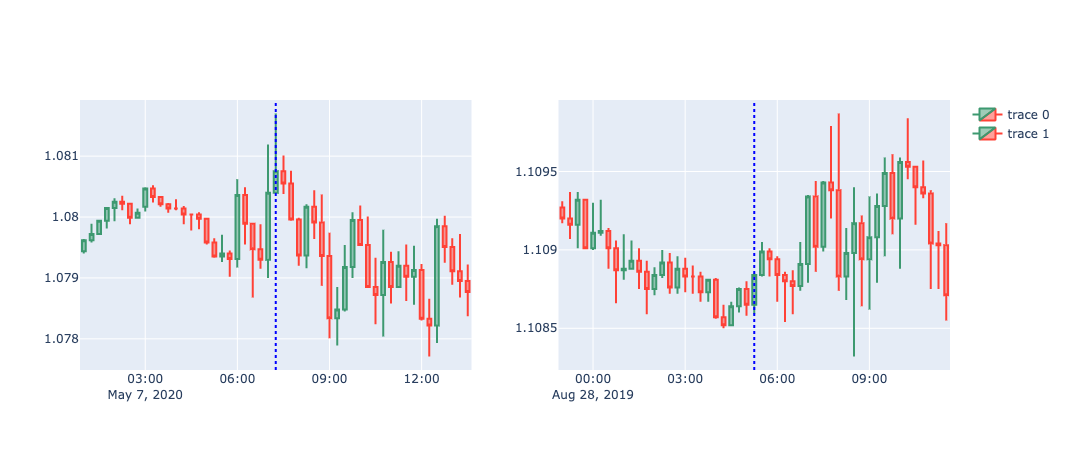

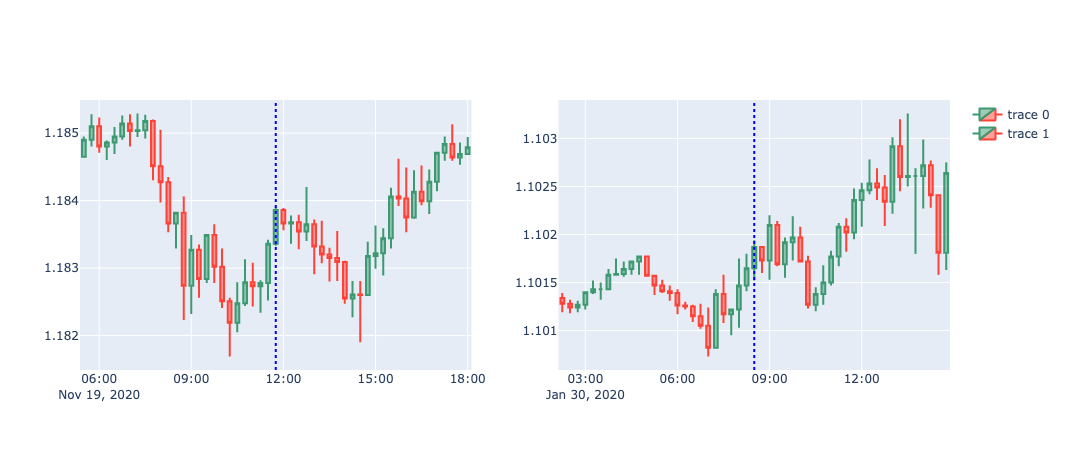

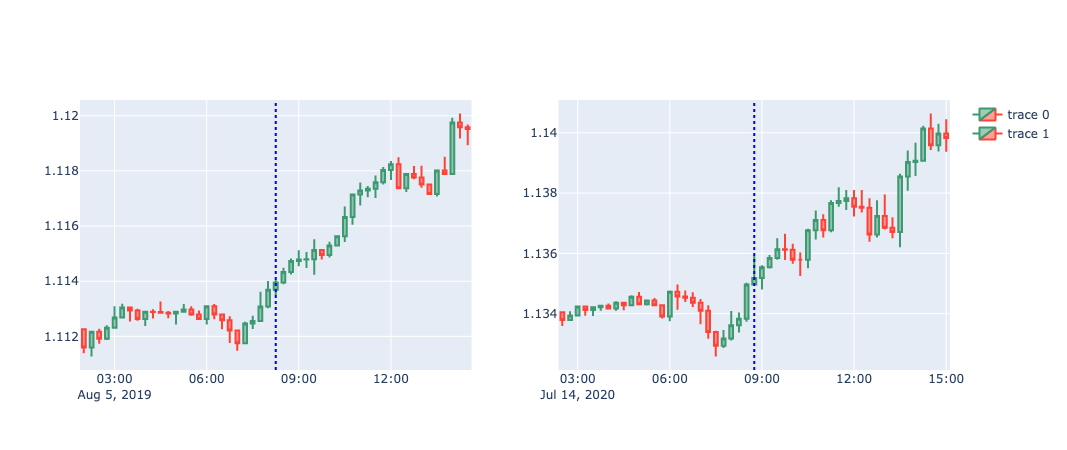

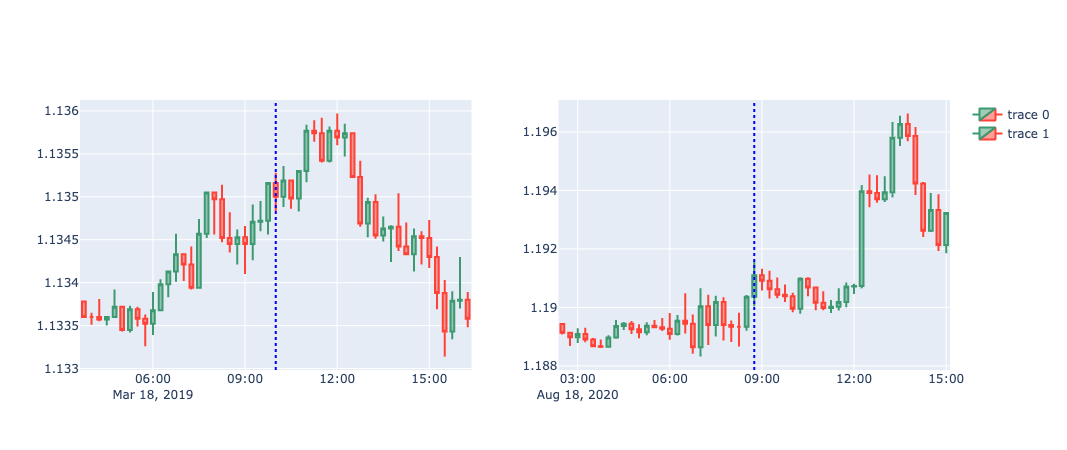

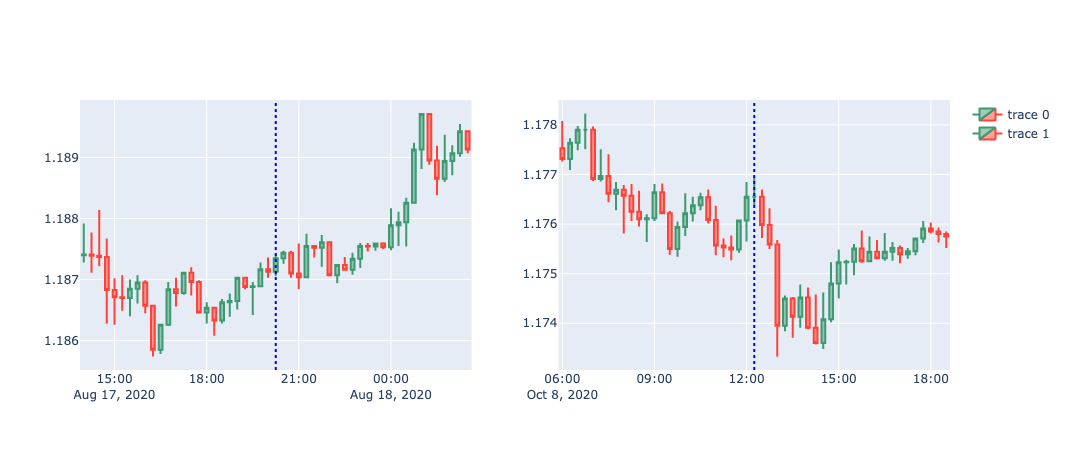

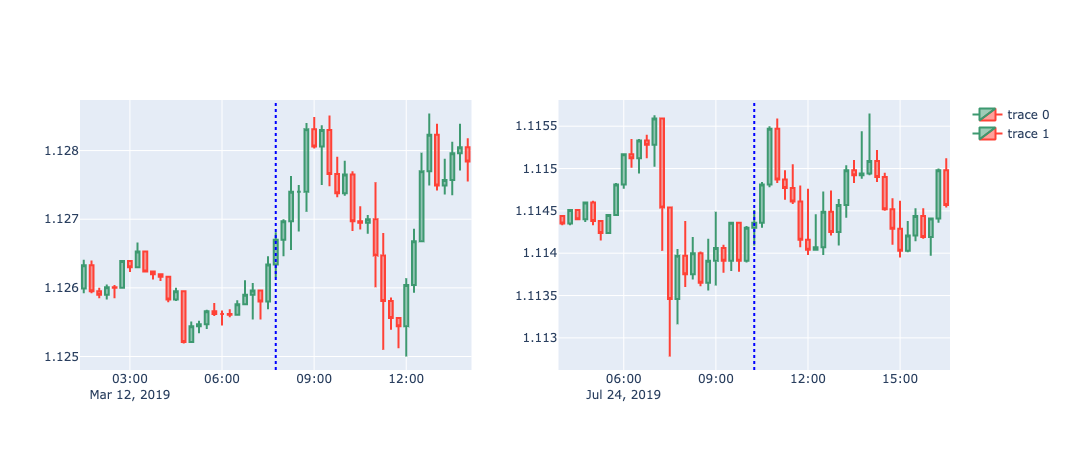

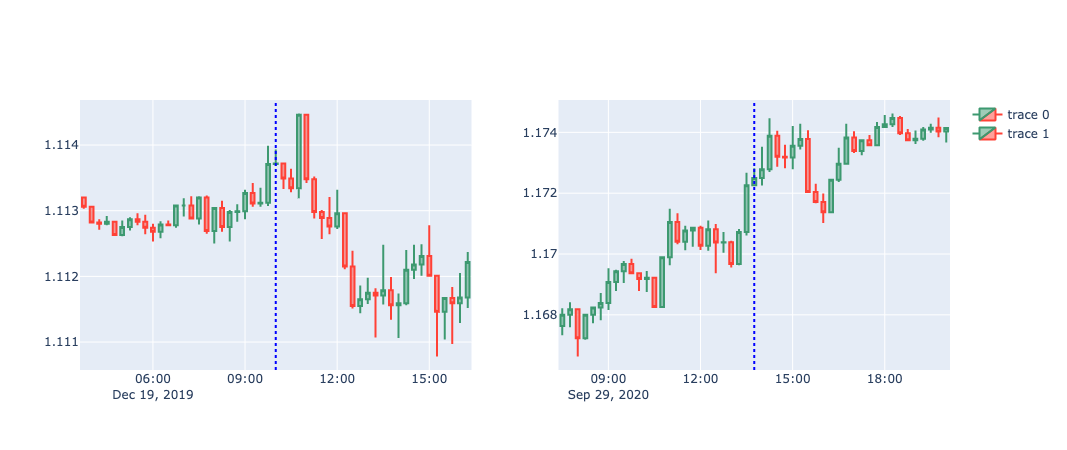

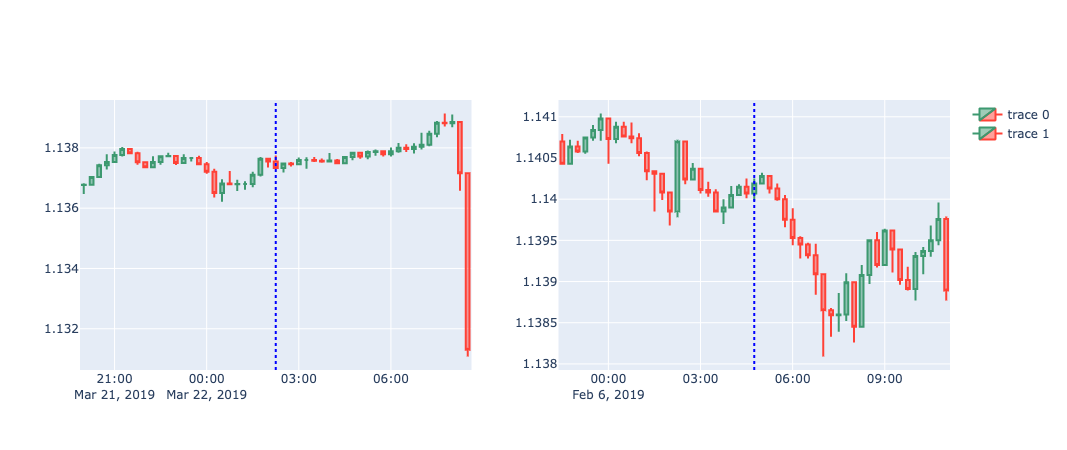

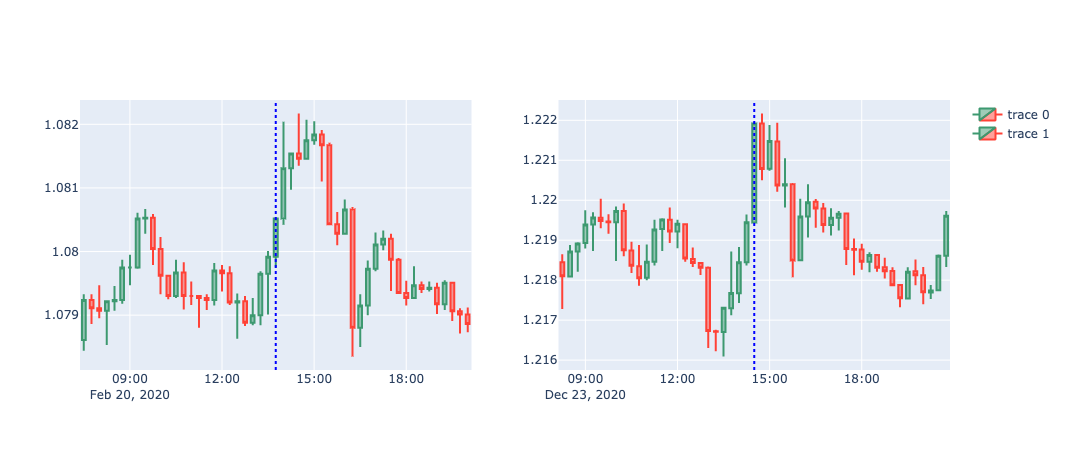

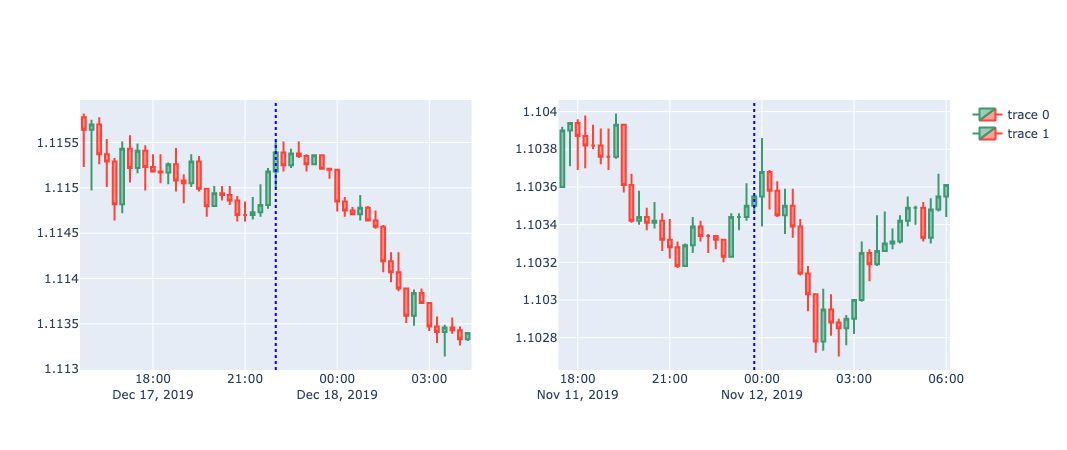

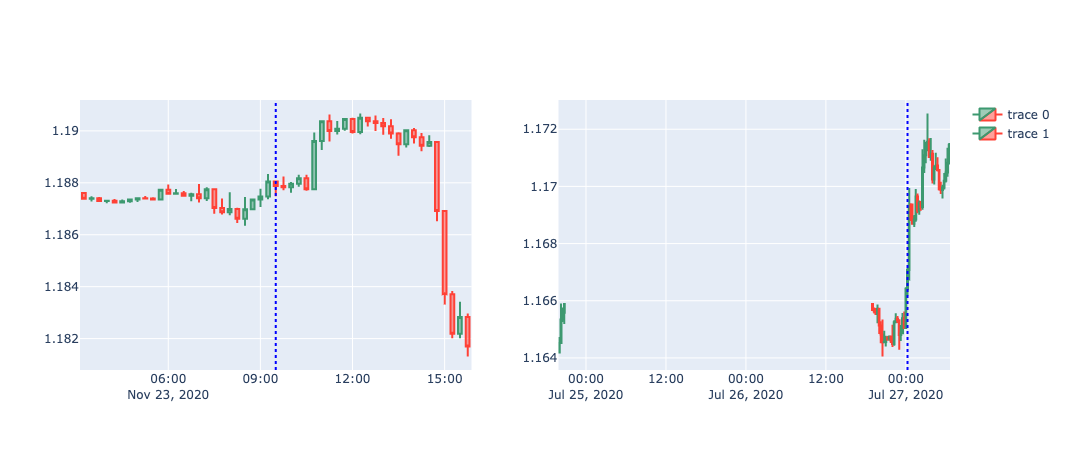

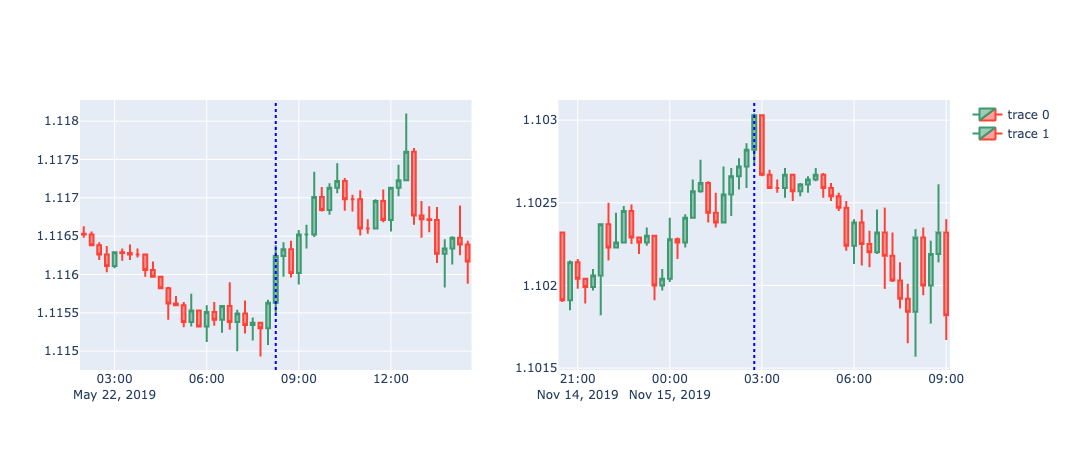

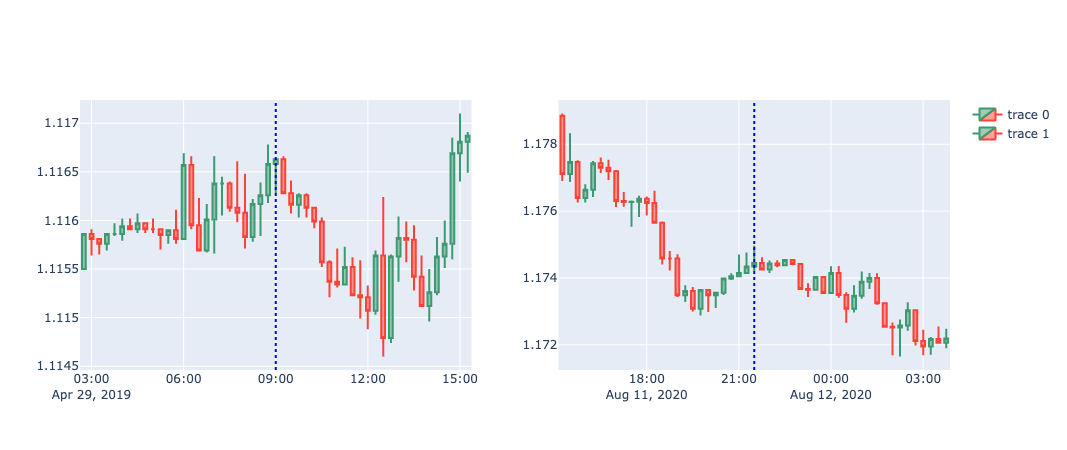

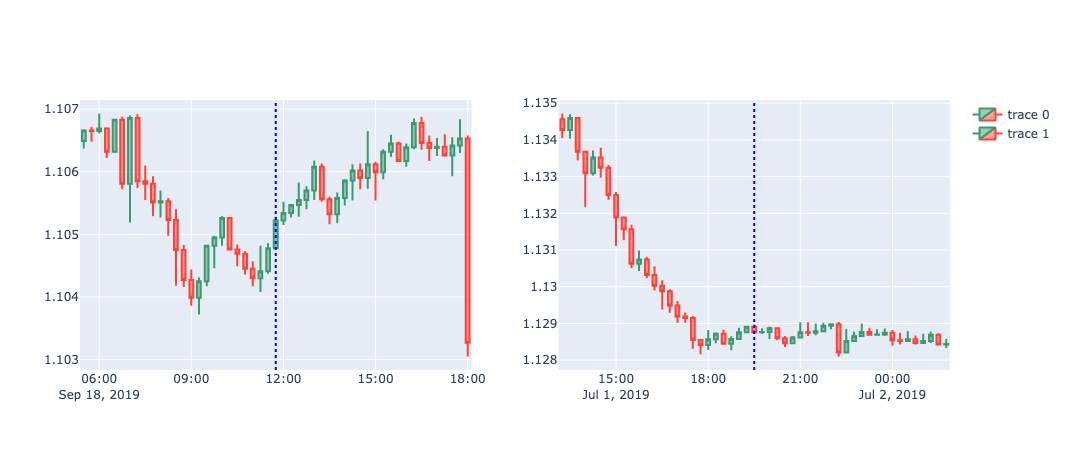

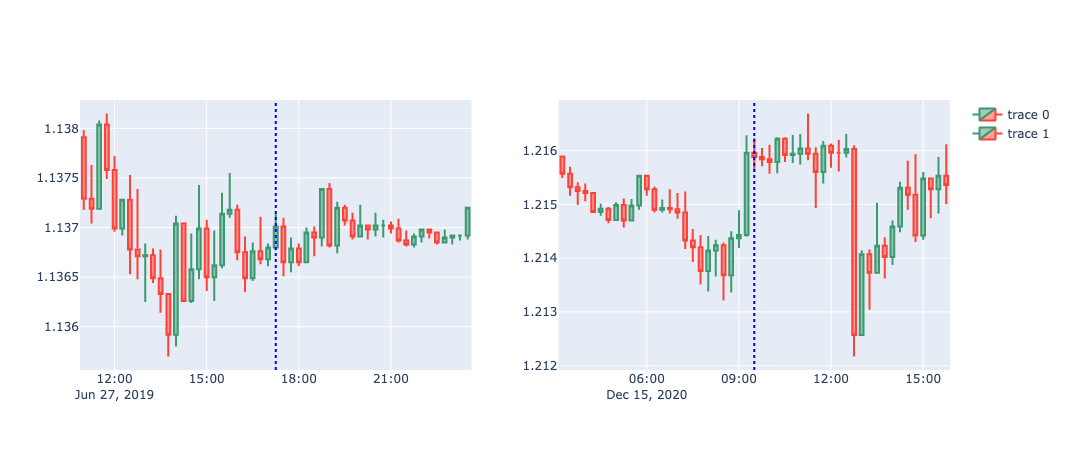

In [39]:
show_random_cases(candles_to_show, indicator_name)

In [8]:
candles_to_show.loc[(candles_to_show['date'] >= '2020-07-01 16:00:00') & (candles_to_show['date'] <= '2020-07-01 17:00:00'), ['date', 'close', 'slope']]

date    close      slope
188333 2020-07-01 16:00:00  1.12553   0.000000
188334 2020-07-01 16:05:00  1.12526   0.000000
188335 2020-07-01 16:10:00  1.12525   0.000000
188336 2020-07-01 16:15:00  1.12553   0.000000
188337 2020-07-01 16:20:00  1.12579   0.000000
188338 2020-07-01 16:25:00  1.12604   0.000000
188339 2020-07-01 16:30:00  1.12599  45.216755
188340 2020-07-01 16:35:00  1.12614   0.000000
188341 2020-07-01 16:40:00  1.12602   0.000000
188342 2020-07-01 16:45:00  1.12588 -24.044223
188343 2020-07-01 16:50:00  1.12614   0.000000
188344 2020-07-01 16:55:00  1.12649   0.000000
188345 2020-07-01 17:00:00  1.12659   0.000000

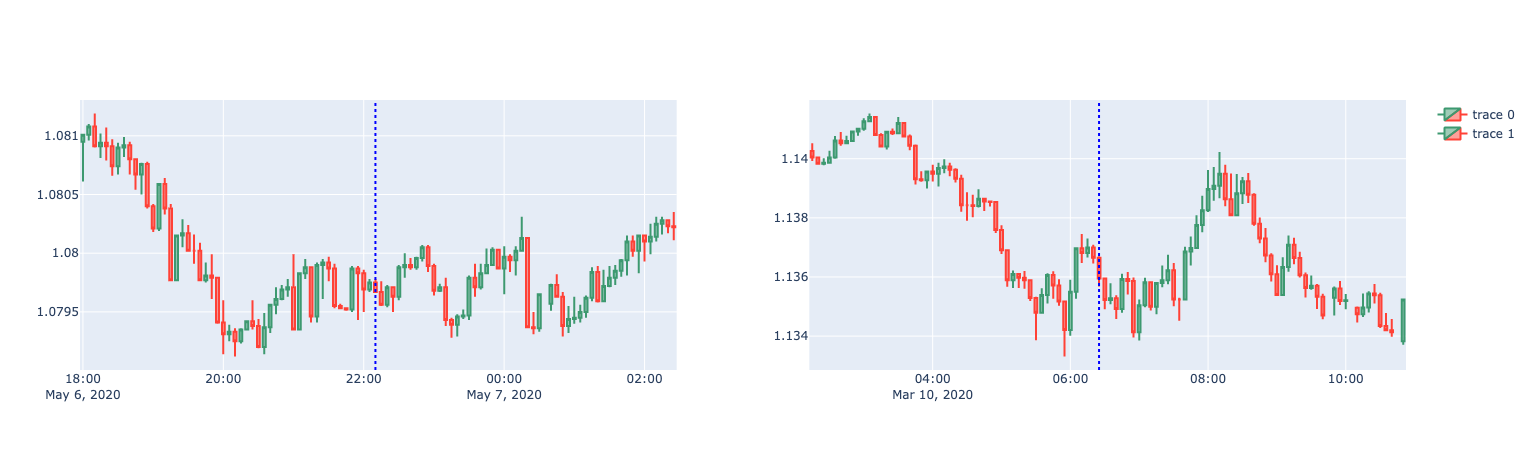

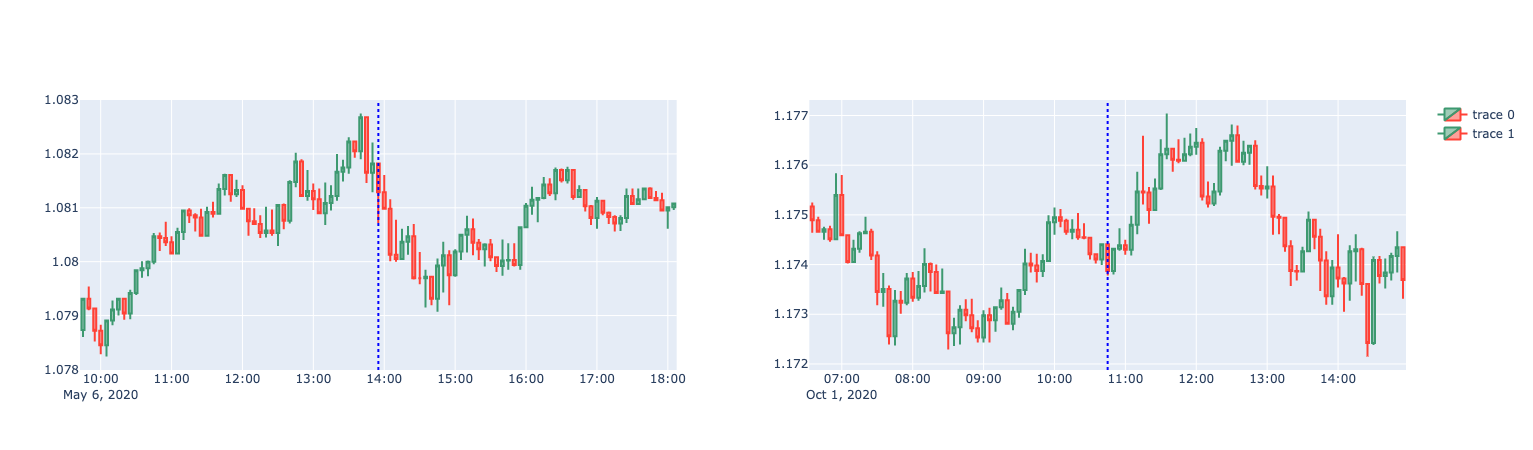

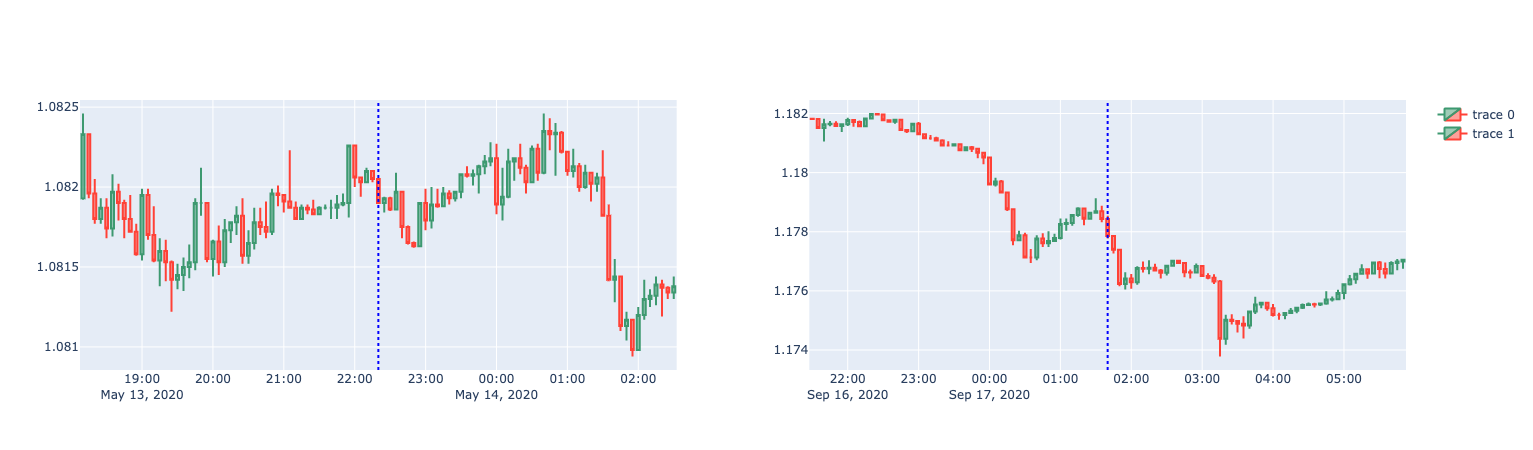

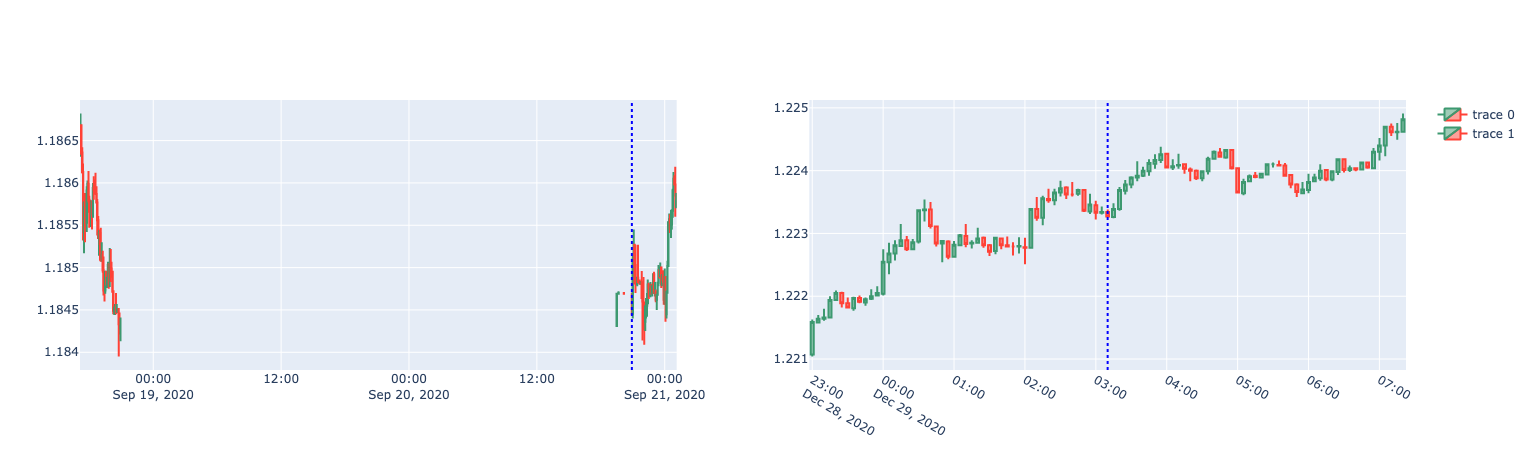

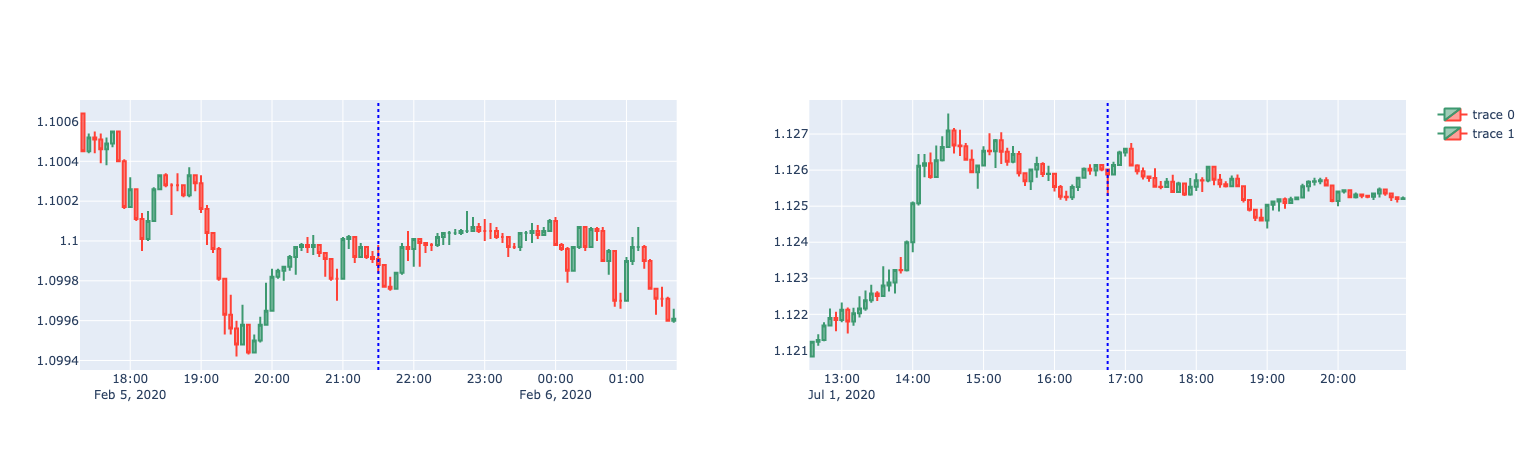

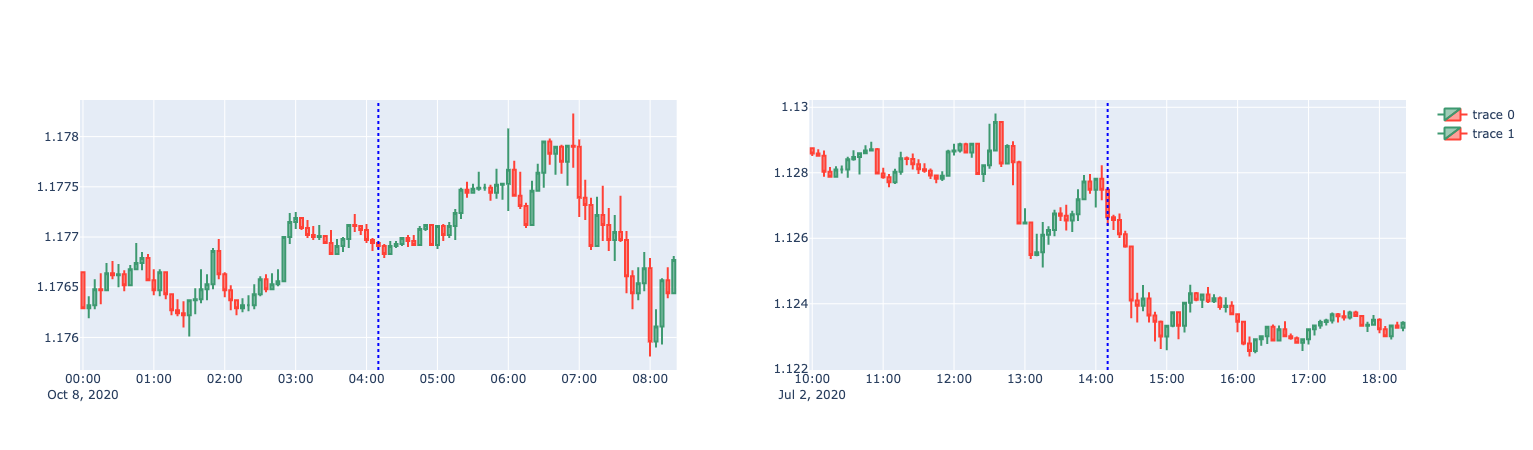

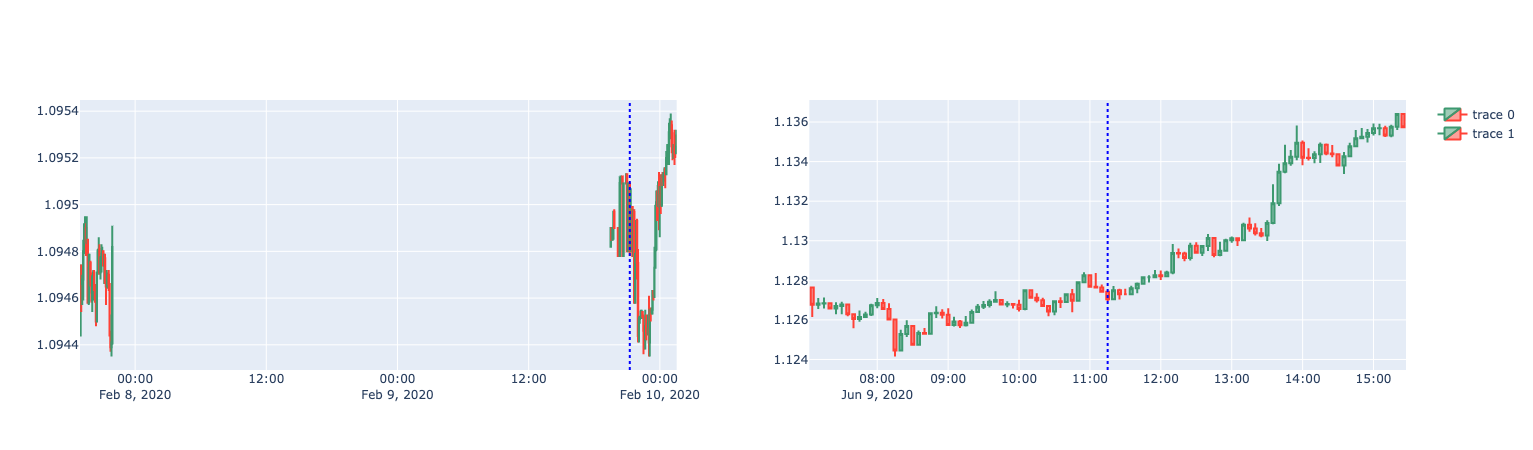

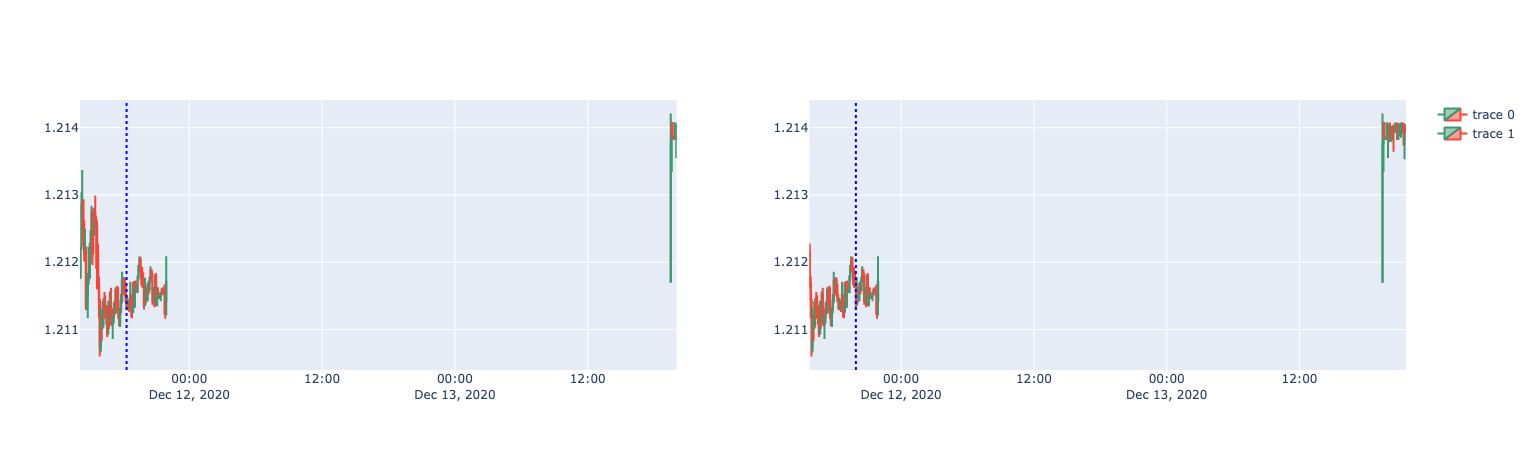

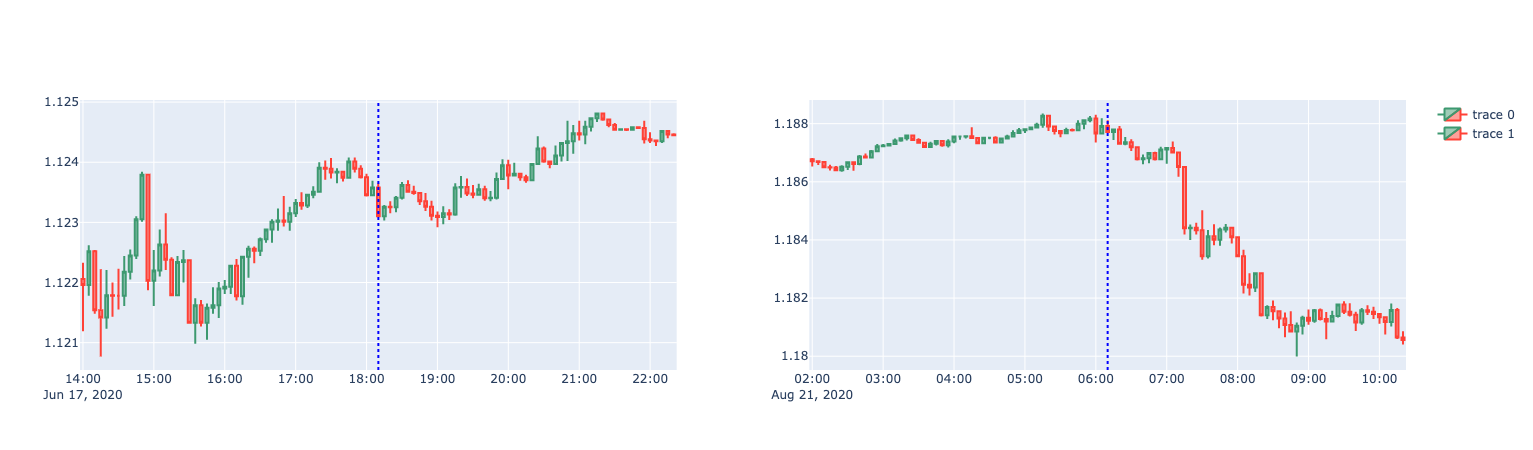

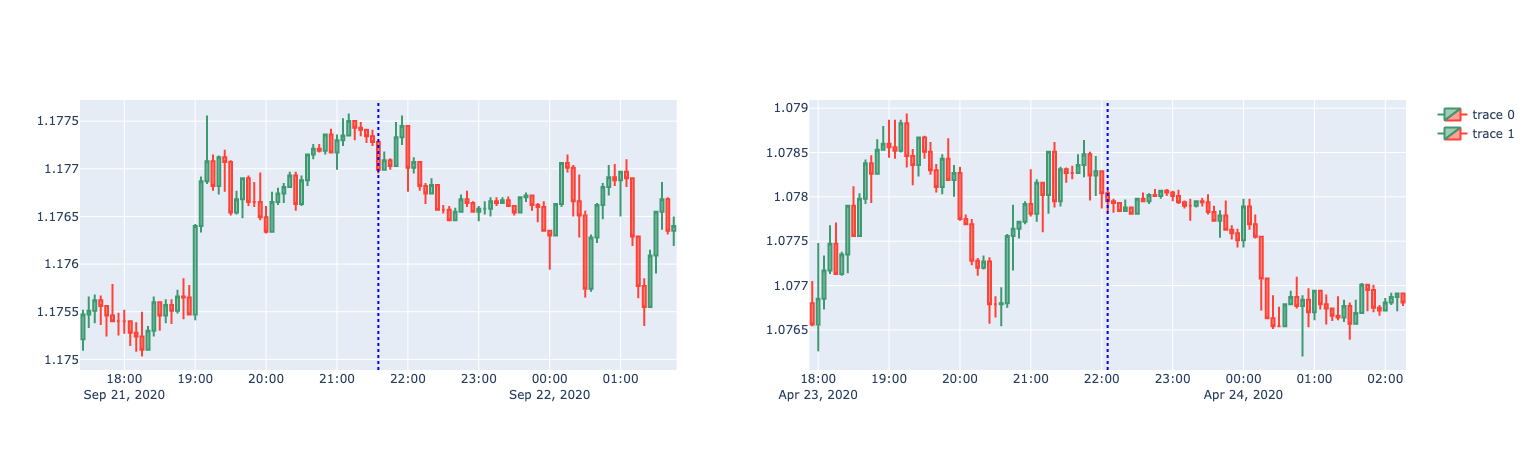

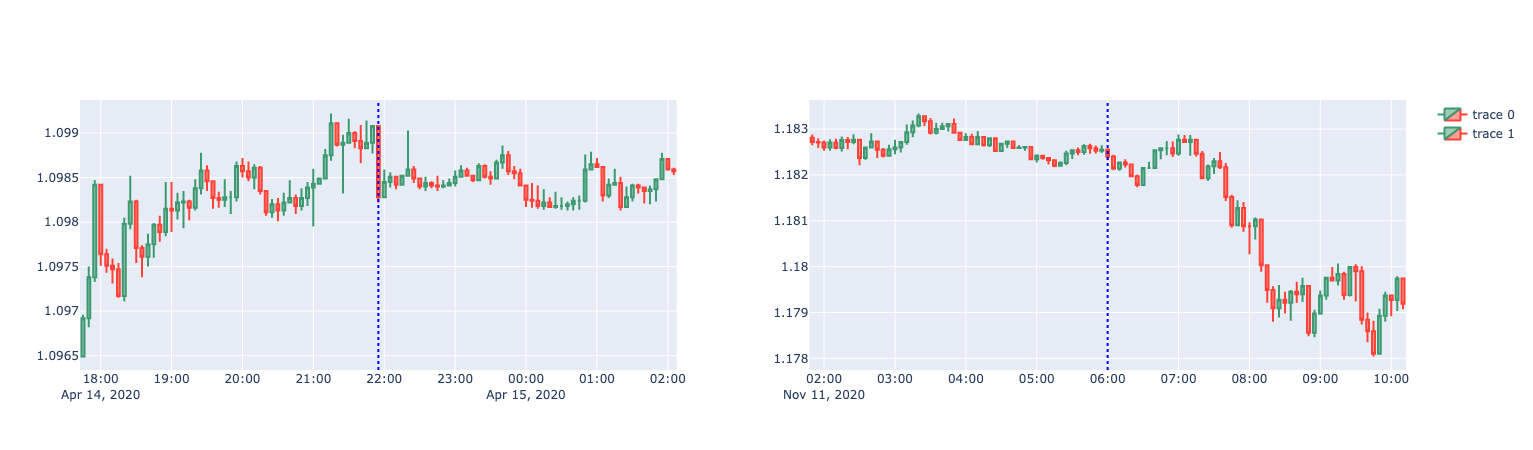

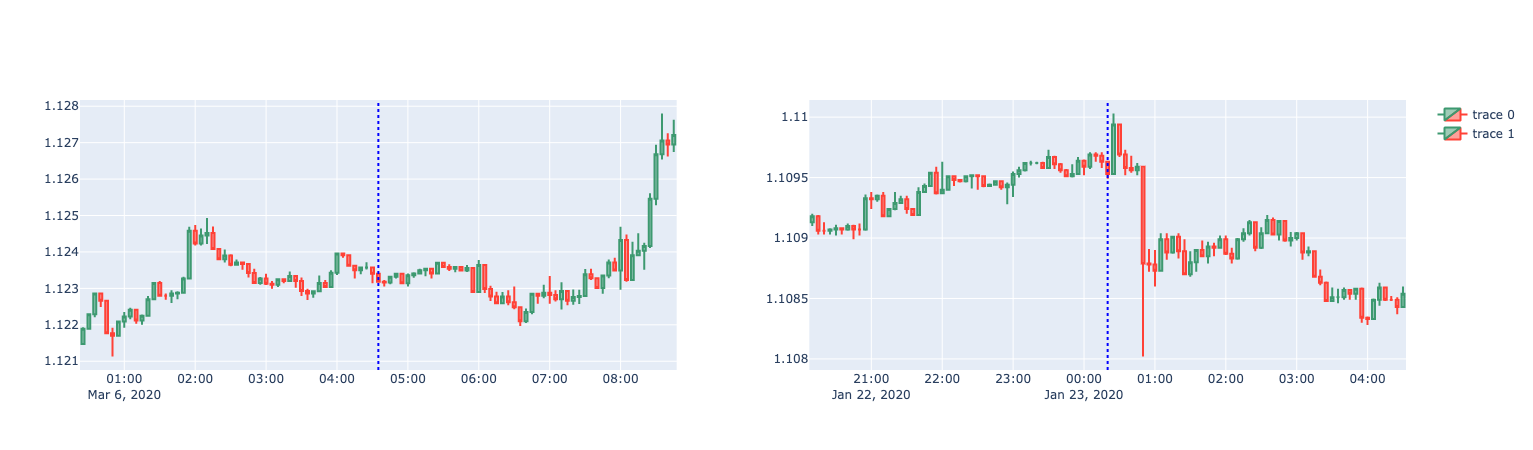

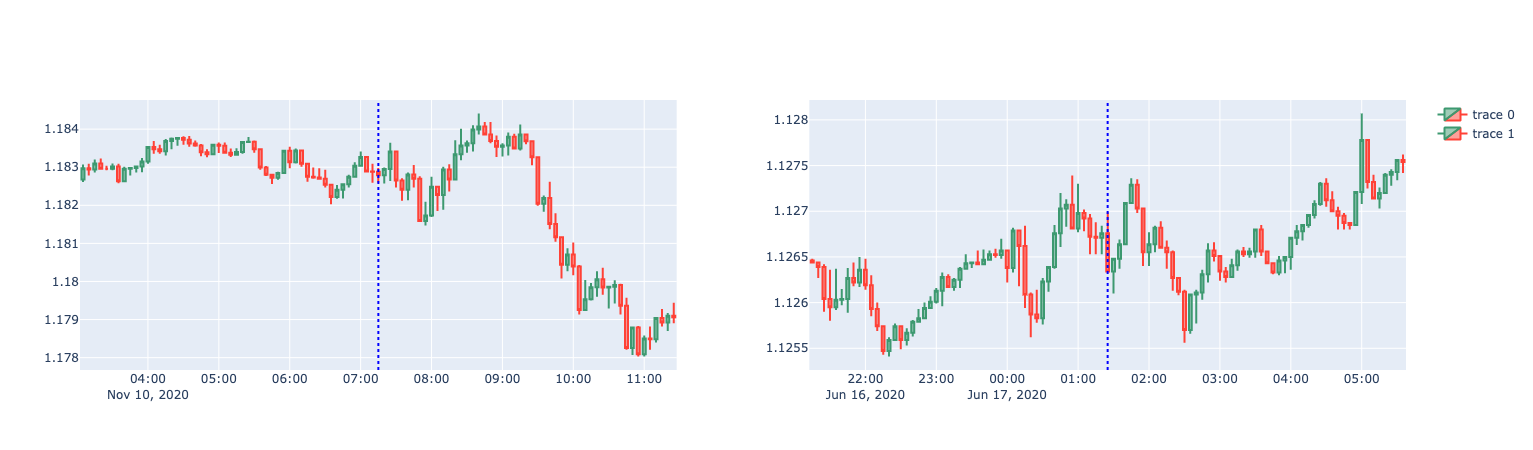

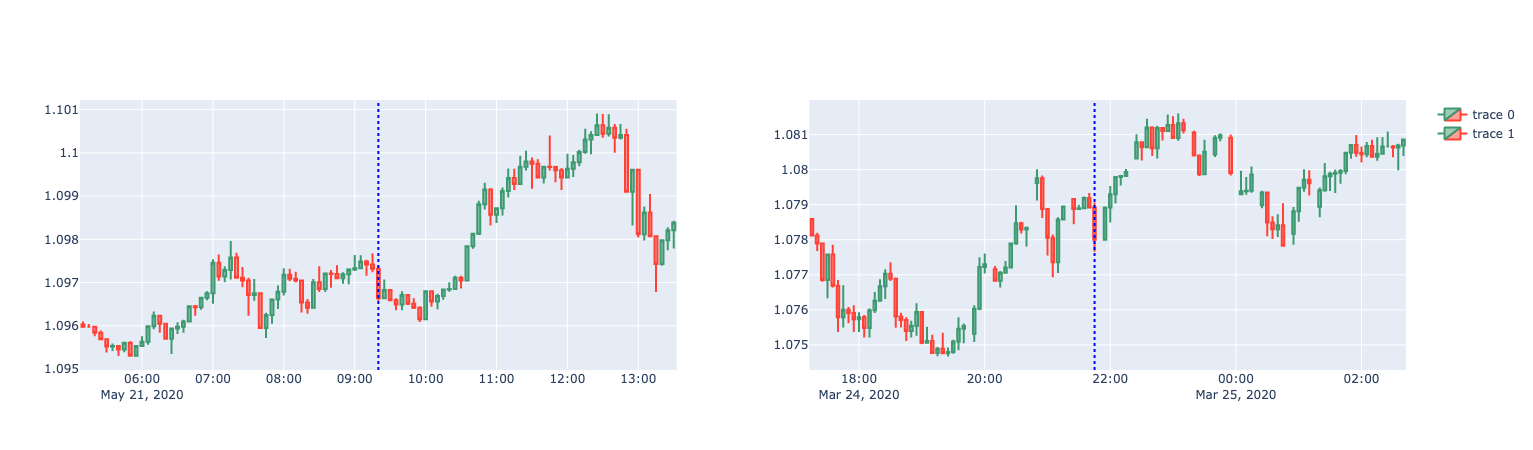

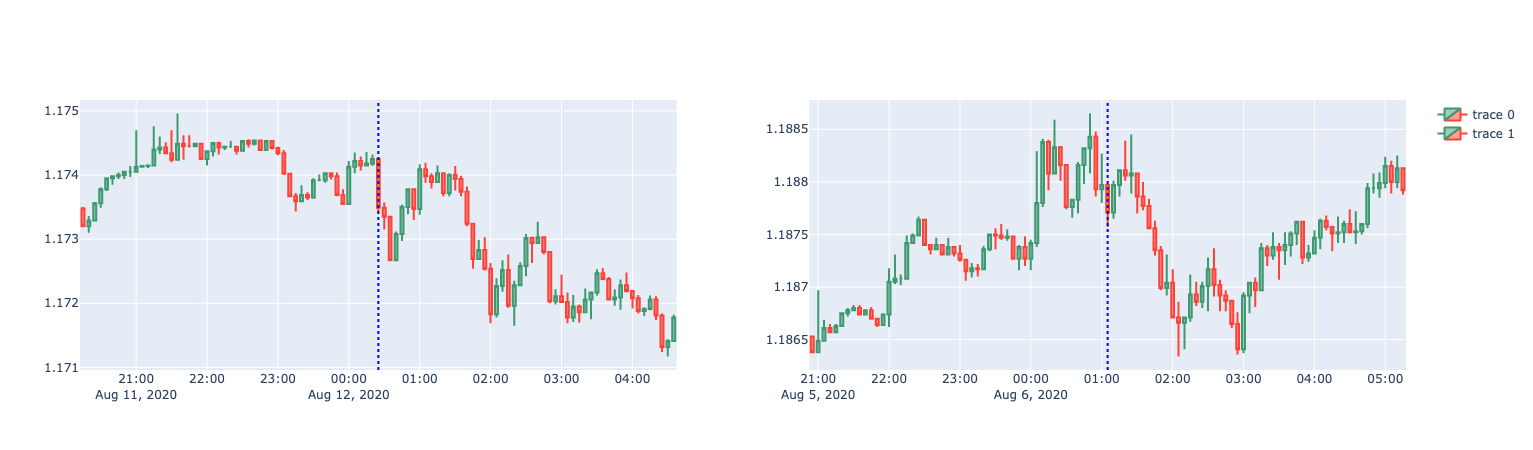

In [270]:
for i, (idx_start, idx_end) in enumerate(range_of_idx_to_show):
    data = candles_to_show.loc[idx_start: idx_end, :]
    idx = nb_candles_to_show // 2 + idx_start
    data_tmp = data.loc[idx, :]
    
    if i % 2 == 0:
        fig = make_subplots(rows=1, cols=2)
    fig.update_layout(xaxis1_rangeslider_visible=False, xaxis2_rangeslider_visible=False)
    fig.update_yaxes(fixedrange=False)

    fig.add_trace(go.Candlestick(x=data['date'],
                                 open=data['open'],
                                 high=data['high'],
                                 low=data['low'],
                                 close=data['close']),
                  row=1, col= i % 2 + 1)
       
    fig.add_vline(x=data_tmp.date, line_dash='dot', line_color='blue', row=1, col= i % 2 + 1)
    if i % 2 == 1:
        fig.show()